# Assignment 1.1: Exploring WS and BA models

## Global setup

In [16]:
# Imports (only what we use)
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import Tuple, List



# Reproducibility
SEED = 123
np.random.seed(SEED)
random.seed(SEED)


# Plot defaults
plt.rcParams.update({
"figure.dpi": 120,
"axes.labelsize": 11,
"axes.titlesize": 12,
"xtick.labelsize": 10,
"ytick.labelsize": 10,
})


# Tidy, labeled printing
from typing import Any


def p(label: str, value: Any):
    print(f"{label}: {value}")


# Helper: average shortest path on largest connected component
import math


def avg_shortest_path_len_lcc(G: nx.Graph) -> float:
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    lcc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    return nx.average_shortest_path_length(lcc)

## A) Did you really read the text? (No calculations)

### Question 1  
**What’s the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?**

In Erdős–Rényi (ER) random graphs, the degree distribution is narrow (approximately Poisson), so almost all nodes have degrees near the mean and true hubs are exponentially unlikely. Real networks exhibit pronounced degree heterogeneity with hubs, which ER graphs cannot reproduce. Therefore ER is a poor model for systems where heavy-tailed degree distributions are observed.

*Ref: Barabási, Network Science, Ch. 3 §3.5.*


### Question 2  
**List the four regimes that characterize random networks as a function of ⟨k⟩.**

The structure of a random network depends on its average degree ⟨k⟩:

- **Subcritical (0 < ⟨k⟩ < 1):** Network breaks into many small tree-like clusters; no giant component.  
- **Critical (⟨k⟩ = 1):** At the percolation threshold; the largest component scales as ~N^(2/3), and cluster sizes follow a power-law distribution.  
- **Supercritical (⟨k⟩ > 1):** A giant component emerges containing a finite fraction of nodes, while small clusters remain.  
- **Connected (⟨k⟩ > ln N):** Almost all nodes are part of a single connected component; the network is still sparse but fully connected.

*Ref: Barabási, Network Science, Ch. 3.*


### Question 3  
**According to the book, why is it a problem for random networks that the degree-dependent clustering C(k) decreases as a function of k in real-world networks?**

In ER graphs clustering is degree-independent and low (C ≈ ⟨k⟩/N), while many empirical networks show a decreasing C(k): high-degree nodes sit at the intersection of otherwise tight local groups. This hierarchical structure violates ER assumptions and implies non-random mechanisms (e.g., triadic closure, communities, preferential attachment) shaping the network.

*Ref: Barabási, Network Science, Ch. 3 §3.8–3.9.*


## B) WS edition

### B.1)
*Build Watts–Strogatz graphs with n = 500, k = 4, and rewiring probabilities p ∈ {0, 0.1, 1}. Compute the average shortest path length ⟨d⟩ for each (use the largest connected component if the graph is disconnected). Report the results.*

In [9]:
n, k = 500, 4
p_list = [0.0, 0.1, 1.0]


# Use a fixed Random Generator to pass plain ints as seeds to NetworkX
rng = np.random.default_rng(SEED)


results = []
for p_val in p_list:
    # Different seeds per instance for fairness, but reproducible overall
    seed_val = int(rng.integers(1_000_000_000))
    G = nx.watts_strogatz_graph(n=n, k=k, p=p_val, seed=seed_val)
    d = avg_shortest_path_len_lcc(G)
    results.append((p_val, d))


for prob, d_val in results:
    print(f"WS ⟨d⟩ (n={n}, k={k}, p={prob}): {d_val:.3f}")

WS ⟨d⟩ (n=500, k=4, p=0.0): 62.876
WS ⟨d⟩ (n=500, k=4, p=0.1): 7.406
WS ⟨d⟩ (n=500, k=4, p=1.0): 4.760


As p increases from 0 to 1, ⟨d⟩ drops sharply. Even modest rewiring (p = 0.1) substantially reduces the characteristic path length compared to the ring lattice (p = 0).

### B.2) 
*Describe what happens to the network when p = 1.*

For p = 1, each edge is rewired uniformly at random, destroying lattice structure and yielding a graph with ER-like path lengths: very short ⟨d⟩ that scale roughly with ln N. Clustering collapses toward the low random baseline, illustrating the random-network limit of the WS model.

### B.3)
*Generate many WS networks across p and estimate how quickly ⟨d⟩ approaches the fully randomized case. Identify the smallest p where ⟨d⟩(p) is within 10% of ⟨d⟩(1).*

In [11]:
n, k = 500, 4
p_values = [0.0, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 1.0]
num_trials = 20


rng = np.random.default_rng(SEED)


def estimate_path_length(n, k, p, trials, rng):
    vals = []
    for _ in range(trials):
        seed_val = int(rng.integers(1_000_000_000))
        G = nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed_val)
        vals.append(avg_shortest_path_len_lcc(G))
    return float(np.mean(vals)), float(np.std(vals))


means, stds = [], []
for p in p_values:
    m, s = estimate_path_length(n, k, p, num_trials, rng)
    means.append(m)
    stds.append(s)


# Find threshold p* where mean is within 10% of the p=1 mean
m1 = means[-1]
threshold = 1.10 * m1
p_star = None
for p, m in zip(p_values, means):
    if m <= threshold:
        p_star = p
        break


print("⟨d⟩ at p=1 (baseline)", f"{m1:.3f}")
print("10% threshold", f"≤ {threshold:.3f}")
print("Smallest p with ⟨d⟩ within 10% of p=1", p_star)

⟨d⟩ at p=1 (baseline) 4.752
10% threshold ≤ 5.228
Smallest p with ⟨d⟩ within 10% of p=1 0.4


The small-world transition is rapid: a small amount of randomness (p ≪ 1) is sufficient to yield path lengths close to the random graph baseline. The printed p* quantifies where ⟨d⟩ falls within 10% of the p = 1 value.

### B.4)

*Generate 50 WS networks for each p in a grid and plot ⟨d⟩ vs p with error bars. Provide a short caption that explains the variables and the takeaway.*

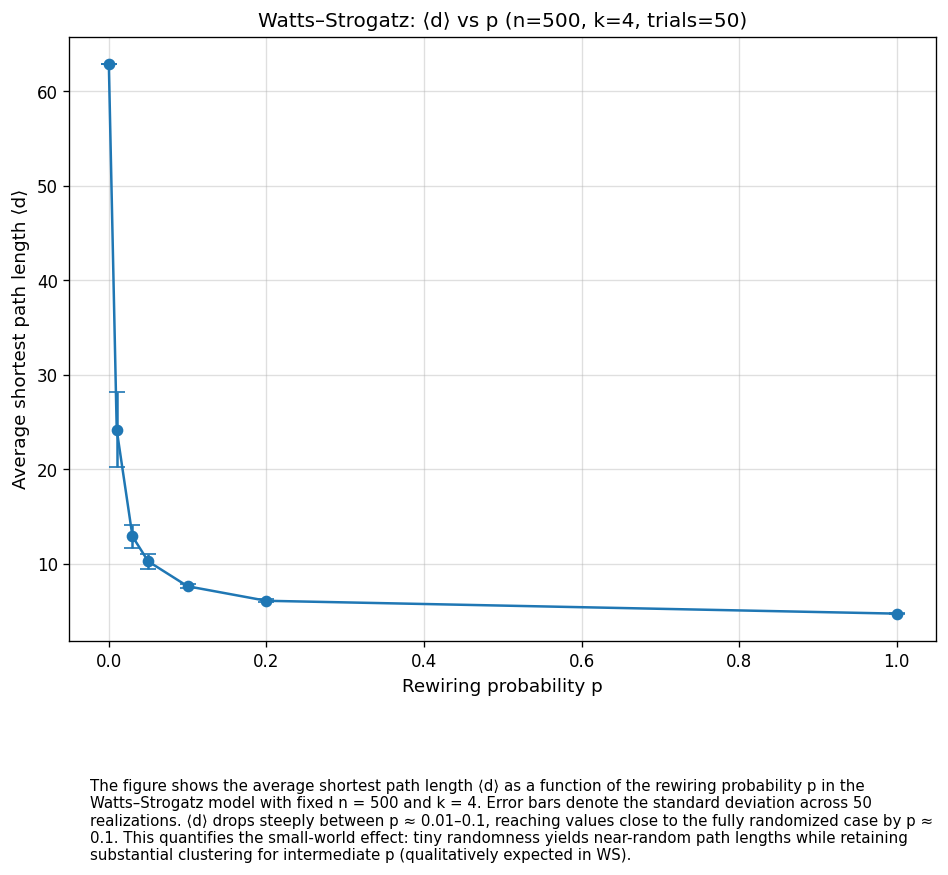

In [ ]:
n, k = 500, 4
p_values = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2, 1.0]
num_trials = 50


rng = np.random.default_rng(SEED)
means, stds = [], []
for p in p_values:
    d_list = []
    for _ in range(num_trials):
        seed_val = int(rng.integers(1_000_000_000))
        G = nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed_val)
        d_list.append(avg_shortest_path_len_lcc(G))
    means.append(float(np.mean(d_list)))
    stds.append(float(np.std(d_list)))


# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(p_values, means, yerr=stds, fmt="o-", capsize=5)
plt.xlabel("Rewiring probability p")
plt.ylabel("Average shortest path length ⟨d⟩")
plt.title(f"Watts–Strogatz: ⟨d⟩ vs p (n={n}, k={k}, trials={num_trials})")
plt.grid(True, alpha=0.4)

# Add caption below the plot
caption = ("The figure shows the average shortest path length ⟨d⟩ as a function of the rewiring probability p in the "
          "Watts–Strogatz model with fixed n = 500 and k = 4. Error bars denote the standard deviation across 50 realizations. "
          "⟨d⟩ drops steeply between p ≈ 0.01–0.1, reaching values close to the fully randomized case by p ≈ 0.1. "
          "This quantifies the small-world effect: tiny randomness yields near-random path lengths while retaining "
          "substantial clustering for intermediate p (qualitatively expected in WS).")
plt.figtext(0.1, -0.2, caption, wrap=True, horizontalalignment='left', fontsize=8)

plt.tight_layout()
plt.show()

The figure shows the average shortest path length ⟨d⟩ as a function of the rewiring probability p in the Watts–Strogatz model with fixed n = 500 and k = 4. Error bars denote the standard deviation across 50 realizations. ⟨d⟩ drops steeply between p ≈ 0.01–0.1, reaching values close to the fully randomized case by p ≈ 0.1. This quantifies the small-world effect: tiny randomness yields near-random path lengths while retaining substantial clustering for intermediate p (qualitatively expected in WS).

## C) BA EDITION

### QUESTION 1
**What are the three slope dependent regimes of complex networks with power-law degree distributions? Briefly describe each one.**

 **γ** is the *slope of the line* that describes how common hubs are:

- **If γ ≤ 2** → the math “blows up” → such networks can’t exist in practice.  
- **If 2 < γ < 3** → true scale-free networks → giant hubs make the network **ultra-connected** (*ultra-small world*).  
- **If γ > 3** → hubs fade away → the network behaves like a random one, without extreme shortcuts.

### QUESTION 2

**What are the three regimes we find in non-linear preferential attachement?**

- **Sublinear (α < 1):** hubs are weak, distribution looks closer to random.  
- **Linear (α = 1):** true scale-free networks with power laws emerge.  
- **Superlinear (α > 1):** one or a few “super hubs” dominate, creating star-like networks.

###  How to build the Barabasi-Albert model
First create a graph consisting of a single link. Now add another node, connecting to an existing node in proportion to its degree. Keep going until you have a **100‑node network**; plot it. Then extend it to **5,000 nodes**. Report the **minimum/maximum degree**, bin the degree distribution with *numpy.histogram*, and plot the distribution with both linear and log‑log axes.


**Initialize the seed graph (single link)**

In [15]:
# Pretty printer for labeled outputs
def p(label, value):
    print(f"{label}: {value}")
# Start from two nodes connected by one edge
G = nx.Graph()
G.add_edge(0, 1)


p("initial |V|, |E|", f"{G.number_of_nodes()}, {G.number_of_edges()}")

initial |V|, |E|: 2, 1


Starting from a single edge guarantees all existing nodes have degree ≥ 1, which avoids zero‑probability nodes when sampling by degree.

**Degree‑proportional attachment (m = 1) — efficient sampler**

In [17]:
def grow_ba_m1(G: nx.Graph, target_n: int, rng: np.random.Generator) -> nx.Graph:
    """Grow the graph to target_n nodes via preferential attachment with m=1.
    Efficiently samples endpoints using a degree-proportional pool.
    """
    # Build initial pool with node IDs repeated by their degree
    pool: List[int] = []
    for u, deg in G.degree():
        pool.extend([u] * deg)


    next_node = max(G.nodes) + 1 if G.number_of_nodes() > 0 else 0


    while G.number_of_nodes() < target_n:
        # Sample an existing node with probability proportional to degree
        # (uniform over the pool equals degree-proportional over nodes)
        attach_to = int(pool[rng.integers(len(pool))])


        # Add the new node and the edge (no self-loop possible since new node is fresh)
        v = next_node
        G.add_edge(v, attach_to)


        # Update pool: +1 copy for attach_to, +1 for the new node (degree 1)
        pool.append(attach_to)
        pool.append(v)


        next_node += 1
    return G

Sampling uniformly from a list that contains each node as many times as its degree implements P(select i) ∝ k_i. Updating the pool after each edge keeps probabilities consistent.

**Grow to 100 nodes and visualize (seeded layout)**

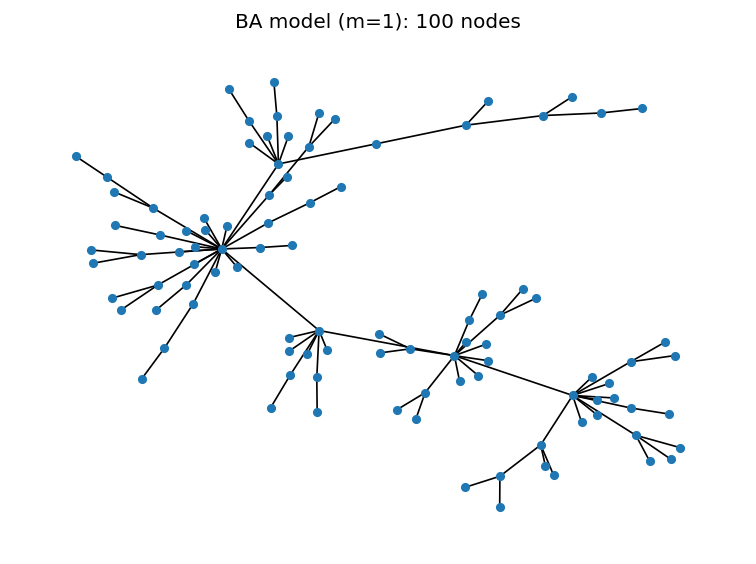

In [18]:
G100 = grow_ba_m1(G.copy(), 100, rng)


# Fixed layout for reproducibility
pos = nx.spring_layout(G100, seed=SEED)
plt.figure()
nx.draw_networkx(G100, pos=pos, with_labels=False, node_size=20)
plt.title("BA model (m=1): 100 nodes")
plt.axis("off")
plt.tight_layout()
plt.show()

The 100‑node BA graph exhibits visible hubs with many spokes, a hallmark of preferential attachment. The spring layout (seeded) places high‑degree nodes near the center, with low‑degree nodes at the periphery.

**Extend to 5,000 nodes and report degree stats**

In [27]:
G5000 = grow_ba_m1(G.copy(), 5000, rng)


# Degree vector and basic stats
deg = np.array([d for _, d in G5000.degree()])
min_k, max_k = int(deg.min()), int(deg.max())
mean_k = float(deg.mean())


p("BA (m=1) |V|, |E|", f"{G5000.number_of_nodes()}, {G5000.number_of_edges()}")
p("min degree k_min", min_k)
p("max degree k_max", max_k)
p("average degree ⟨k⟩", f"{mean_k:.3f}")

BA (m=1) |V|, |E|: 5000, 4999
min degree k_min: 1
max degree k_max: 183
average degree ⟨k⟩: 2.000


In the m=1 BA model, the mean degree stays close to 2m = 2 by construction (each new node adds one edge). The maximum degree grows sublinearly with N, indicating the emergence of hubs.

**Degree distribution — linear and log–log views**

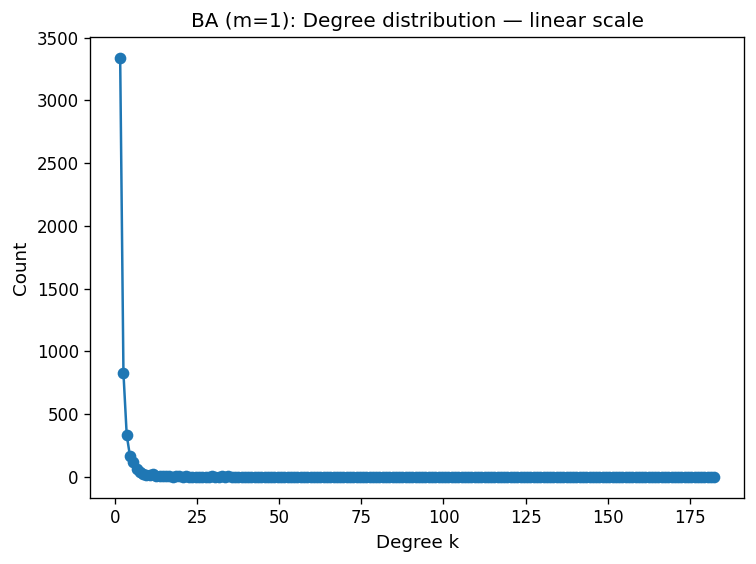

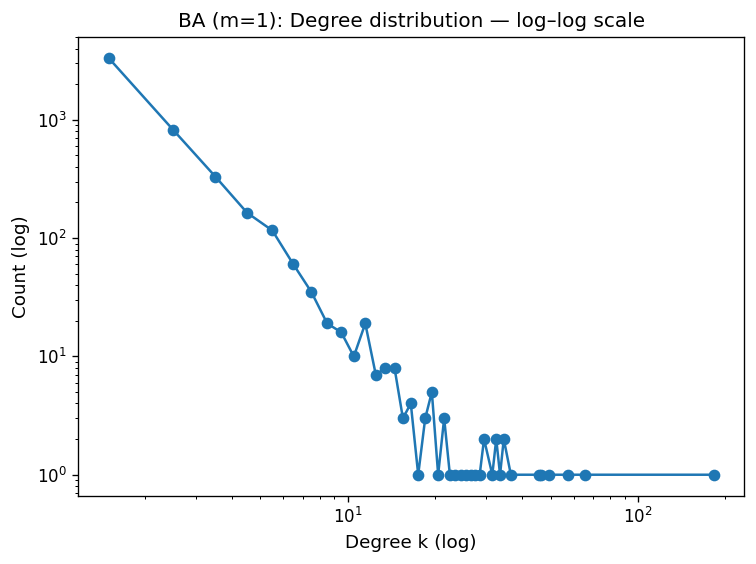

In [28]:
# Histogram bins (auto); return counts and bin edges
counts, bin_edges = np.histogram(deg, bins="auto")
centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


# Linear scale
plt.figure()
plt.plot(centers, counts, marker="o")
plt.xlabel("Degree k")
plt.ylabel("Count")
plt.title("BA (m=1): Degree distribution — linear scale")
plt.tight_layout()
plt.show()


# Log–log scale
plt.figure()
# Add +1 to avoid log(0) for empty bins; omit zeros by masking instead
mask = counts > 0
plt.loglog(centers[mask], counts[mask], marker="o")
plt.xlabel("Degree k (log)")
plt.ylabel("Count (log)")
plt.title("BA (m=1): Degree distribution — log–log scale")
plt.tight_layout()
plt.show()

On linear axes the distribution is highly right‑skewed, dominated by many low‑degree nodes and a few hubs. On log–log axes the upper tail is approximately straight, consistent with a heavy‑tailed (power‑law‑like) degree distribution expected from preferential attachment. Precise tail fitting is out of scope here and should use rigorous methods.

## References

- Barabási, A.-L. Network Science (OpenBook), Ch. 3 (small-worlds, clustering).
- NetworkX documentation: Watts–Strogatz graphs and shortest paths.
- Barabási, Network Science, Ch. 4–5